### Pregunta 1
La Base de Datos Concrete contiene im ́agenes de paredes de concreto con grietas (Positive) y sin grietas (Negative). Siguiendo las buenas pr ́acticas aprendidas en el curso y utilizando Pytorch.

1.1 Leer las imagenes desde ambos directorios (Positive y Negative) y generar un conjunto de datos (X, y), con X el tensor de entrada e y las etiquetas de clases. Luego, construir los subconjuntos de entrenamiento y de validacion, tomando el 70% de los datos para el entrenamiento.

In [44]:
#Librerias
import os
#Funcion 
def ReadFolders(root):
    #Ruta folder 'Concrete'
    img_path = []
    img_class = []
    #Folders dentro de 'Concrete'
    for class_dir in os.listdir(root):
        #Ignorar el archivo 'leeer.txt'
        if class_dir == 'leeer.txt':
            continue
        #Ruta folders
        class_dir_path = os.path.join(root, class_dir)
        #Ruta de las imagenes dentro de los folders
        elems = [os.path.join(class_dir_path, x) for x in os.listdir(class_dir_path)]
        #Se agregan a la lista de rutas
        img_path.extend(elems)
        #Se le asigna clase '1' a las imagenes de la carpeta 'Positive' 
        if class_dir == 'Positive':
            img_class.extend([1 for _ in range(len(elems))])
        #Se le asigna clase '0' a las imagenes de la carpeta 'Negative' 
        else:
            img_class.extend([0 for _ in range(len(elems))])
    return img_path, img_class
img_path, img_class = ReadFolders(root='Concrete')

In [45]:
#Librerias 
from sklearn.model_selection import train_test_split

#Data size
img_path_idxs = list(range(len(img_path)))
#Indices de los archivos que seran para el entrenamiento (70%) y validacion (30%)
x_train, x_val, y_train, y_val = train_test_split(img_path_idxs, img_class, test_size=0.3, random_state=0, stratify=img_class)

In [46]:
#Librerias
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
#Clase que creara los conjuntos de imagenes en forma tensorial
class CustomImageDataset(Dataset):
    def __init__(self, img_path, img_class, img_idxs):
        self.split_indexes = img_idxs
        self.path = np.array(img_path)[img_idxs]
        self.labels = np.array(img_class)[img_idxs]
    def __len__(self):
        return len(self.split_indexes)
    def __getitem__(self, idx):
        image = torchvision.io.read_image(self.path[idx]).float()
        label = torch.tensor(self.labels[idx])
        return image, label
#Dataset
train_ds = CustomImageDataset(img_path, img_class, x_train)
valid_ds = CustomImageDataset(img_path, img_class, x_val)
#DataLoader
batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle = True)
valid_dl = DataLoader(valid_ds,batch_size=batch_size, shuffle = True)

1.2 Ajustar una Red Convolucional (CNN) para predecir si una nueva imagen de una pared de concreto tiene o no tiene grieta. Mostrar las curvas de aprendizaje del modelo durante el entrenamiento (para los conjuntos de entrenamiento y de validacion), considerando la Funcion de Perdida y la
Exactitud. ¿Existe sobreajuste o bajo ajuste?

In [47]:
#Tamaxo de las imagenes
from PIL import Image
# Ruta de la imagen
ruta_imagen = img_path[0]
# Cargar la imagen utilizando PIL
imagen = Image.open(ruta_imagen)
# Obtener las dimensiones de la imagen
ancho, alto = imagen.size
# Imprimir las dimensiones de la imagen
print(f'{ancho}x{alto} pixeles')

227x227 pixeles


In [48]:
from torch import nn

#Capas del modelo
model = nn.Sequential()
# Conv -> ReLU -> MaxPooling
model.add_module('conv1', nn.Conv2d(in_channels=3,out_channels=32,kernel_size=5,padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=5))
# Conv -> ReLU -> MaxPooling
model.add_module('conv2', nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=5))
# Flatten
model.add_module('flatten', nn.Flatten())
# Full Connected -> ReLU -> Dropout
model.add_module('fc1', nn.Linear(5184,1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p= .5))
# Full Connected
model.add_module('fc2', nn.Linear(1024, 2))

In [49]:
# Selección de la unidad de procesamiento
processing_unit = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(processing_unit)
model.to(device)
print(f"You're using: {device} as device.")

You're using: cuda as device.


In [50]:
from torchinfo import summary
summary(model,input_data = torch.randint(0, 255, (batch_size, 3, 227, 227))/ 255,
        col_names=["output_size", "num_params"], verbose= 0, device= device)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [128, 2]                  --
├─Conv2d: 1-1                            [128, 32, 227, 227]       2,432
├─ReLU: 1-2                              [128, 32, 227, 227]       --
├─MaxPool2d: 1-3                         [128, 32, 45, 45]         --
├─Conv2d: 1-4                            [128, 64, 45, 45]         51,264
├─ReLU: 1-5                              [128, 64, 45, 45]         --
├─MaxPool2d: 1-6                         [128, 64, 9, 9]           --
├─Flatten: 1-7                           [128, 5184]               --
├─Linear: 1-8                            [128, 1024]               5,309,440
├─ReLU: 1-9                              [128, 1024]               --
├─Dropout: 1-10                          [128, 1024]               --
├─Linear: 1-11                           [128, 2]                  2,050
Total params: 5,365,186
Trainable params: 5,365,186
Non-trainable pa

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= .001)

In [9]:
from sklearn.metrics import confusion_matrix
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= .001)
def train(model, num_epochs, train_dl, valid_dl, device):
    loss_hist_train = torch.zeros(num_epochs).to(device)
    accuracy_hist_train = torch.zeros(num_epochs).to(device)
    loss_hist_valid = torch.zeros(num_epochs).to(device)
    accuracy_hist_valid = torch.zeros(num_epochs).to(device)
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to(device,dtype=torch.float), y_batch.to(device,dtype=torch.long)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch, y_batch = x_batch.to(device,dtype=torch.float), y_batch.to(device,dtype=torch.long)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} 'f'val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train.cpu(), loss_hist_valid.cpu(), accuracy_hist_train.cpu(), accuracy_hist_valid.cpu()

torch.manual_seed(1)
num_epochs = 5
hist = train(model, num_epochs, train_dl, valid_dl, device)
torch.save(model.state_dict(), 'modelo.pth')

Epoch 1 accuracy: 0.9205 val_accuracy: 0.9832
Epoch 2 accuracy: 0.9844 val_accuracy: 0.9893
Epoch 3 accuracy: 0.9870 val_accuracy: 0.9863
Epoch 4 accuracy: 0.9907 val_accuracy: 0.9902
Epoch 5 accuracy: 0.9912 val_accuracy: 0.9922


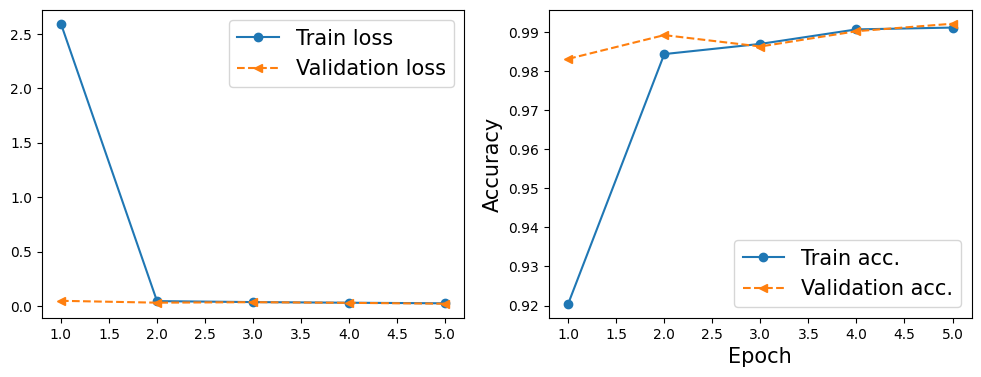

In [10]:
#Librerias
import matplotlib.pyplot as plt

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize= (12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

NO HAY OVERFITTING O UNDERFITTINGTTTTTTT

1.3 Considerando el conjunto de validacion, calcular y mostrar la matriz de confusion del modelo obtenido en el item anterio. Determinar tambien las siguientes metricas de rendimiento: Exactitud (Acc), Tasa de Verdaderos Positivos (TPR), Tasa de Falsos Positivos (FPR), Coeficiente Kappa de
Cohen (K) y Coeficiente de Correlacion de Matthews (MCC).

----- Matriz de Confusion ----- 


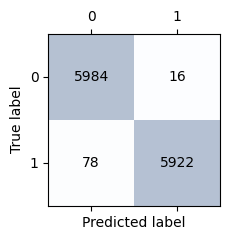

-------------------------------
Metricas:
Accuracy: 0.992
TPR: 0.987
FPR: 0.003
CohenKappaScore: 0.984
MCC: 0.984


In [16]:
#librerias
from sklearn.metrics import accuracy_score, matthews_corrcoef, cohen_kappa_score,confusion_matrix
from sklearn.metrics import confusion_matrix
#prediccion del modelo con el conjunto 'valid_dl'
model.eval()
_pred = []
_val = []
with torch.no_grad():
    for x, y in valid_dl:
        x = x.to(device)
        #Se obtene las predicciones del modelo entregandole x del conjunto 'valid_dl'
        pred = model(x)
        #El conjunto trabaja con batch size de 128, todos los resultados se acoplan a una lista de tensores, esto se aplica para 
        #el conjunto original y el predicho
        _pred.extend(pred)
        _val.extend(y)
#Funcion que toma los tensores creados anteriormente y los tranfroma a una lista binaria
pred = []
val = []
for tensor1,tensor2 in zip(_pred,_val):
    #La pocision del valor maximo indica a la clase que pertenece
    tensor1 = torch.argmax(tensor1)
    tensor1 = tensor1.to('cpu')
    tensor2 = tensor2.to('cpu')
    valu1 = tensor1.item()
    valu2 = tensor2.tolist()
    pred.append(valu1)
    val.append(valu2)
#Matriz de confucion y metricas
def confusion_matrix_and_metrics(y_val,y_pred):
    #matriz de confusion
    confmat = confusion_matrix(y_val,y_pred)
    #Ploteo matriz de confusion
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    #plt.savefig('images/06_09.png', dpi=300)
    plt.show()
    #metricas 
    #true negatives is c(0,0), false negatives is c(1,0), true positives is c(1,1) and false positives is c(0,1)
    true_negative = confmat[0][0]
    false_negative = confmat[1][0]
    true_positives = confmat[1][1]
    false_positives = confmat[0][1]
    #print(confmat)
    #Accuracy
    score = accuracy_score(y_val, y_pred)
    #Tasa de Verdaderos Positivos
    tpr = true_positives/(false_negative + true_positives)
    #Tasa de Falsos Positivos
    fpr = false_positives/(false_positives + true_negative)
    #Coeficiente Kappa de Cohen    
    k = cohen_kappa_score(y_val, y_pred)
    #Coeficiente de Correlacion de Matthews 
    mcc = matthews_corrcoef(y_val, y_pred)
    print('-------------------------------')
    print('Metricas:')
    print('Accuracy: %.3f' %(np.mean(score)))
    print('TPR: %.3f' % (np.mean(tpr)))
    print('FPR: %.3f' % (np.mean(fpr)))
    print('CohenKappaScore: %.3f' % (np.mean(k)))
    print('MCC: %.3f' % (np.mean(mcc)))
    return
print('----- Matriz de Confusion ----- ')
confusion_matrix_and_metrics(val,pred)


1.4 Por cada capa del modelo, calcular la cantidad de parametros (pesos). Agregar el detalle del calculo.

Capa Conv1: A la imgen se le aplican 32 kernels (out_channels) de tamaño 5x5 (kernel size), imagen RGB que corresponde a dimension 3 (in_channels).
Calculo pesos: 32 x 5x5 x 3 + 32 = 2432 pesos

Capa Conv2: se aplican 64 kernels (out_channels) de tamaño 5x5 (kernel size) y 32 pesos de la capa anterior.
Calculo pesos: 64 x 5x5 x 32 + 64 = 51264 pesos

Capa Flatten: reduce la cantidad de pesos de la capa anterior a la cantidad de pesos que pide la capa siguente (fc1), en este caso se reducen a 5184 pesos

Capa fc1(Linear): 5184 pesos de entrada por 1024 pesos de salida.
Calculo pesos: 5184 x 1024 + 1024 = 5309440 pesos

Capa fc2(Linear): 1024 pesos de entrada por 2 pesos de salida.
Calculo pesos: 1024 x 2 + 2 = 2050 pesos

### Pregunta 2
La Base de Datos Escritura arabe contiene imagenes de los simbolos arabes que representan las letras del abecedario. Cada muestra en los directorios Train y Test es una imagen etiquetada. Esta etiqueta viene dada en el nombre del archivo. Por ejemplo, la primera imagen del conjunto Test tiene el nombre id_1_label_1 y pertenece a la clase con etiqueta 1, la segunda imagen del conjunto Test tiene el nombre id_2_label_1 y tambien pertenece a la clase con etiqueta 1; la tercera imagen tiene el nombre id_3_label_2 y pertenece a la clase con etiqueta. Con esta informacion, siguiendo las buenas practicas aprendidas en el curso y utilizando Pytorch.

2.1. Leer las imagenes desde los directorios Train y Test y almacenarlas como muestras en un DataFrame de Pandas (uno por carpeta). Ademas, generar una columna en cada DataFrame que contenga la etiqueta de clase asociada a cada muestra. ¿Cuantas clases distintas existen? ¿Cuantos datos hay por clase en el conjunto Train y en el conjunto Test?



In [63]:
#Librerias
import pandas as pd
#Funcion
def ReadFolders(root):
    #Ruta folder 'Concrete'
    img_path = []
    img_class = []
    #Folders dentro de la ruta
    for class_dir in os.listdir(root):
        #Ruta folders
        class_dir_path = os.path.join(root, class_dir)
        #Ruta de las imagenes dentro de los folders
        elems = [os.path.join(class_dir_path, x) for x in os.listdir(class_dir_path)]
        #Se agregan a la lista de rutas
        img_path.extend(elems)
        #Clases dentro de las carpetas
        if class_dir == os.listdir(root)[0]:
            #Se considera claso con clase de un digito y clases de dos digitos
            img_class.extend([(int(x[-5])-1) if x[-6] == '_' else (int(x[-6:-4])-1) for x in elems])
    return img_path, img_class
#ruta y clase
img_train_path, img_train_class = ReadFolders(root='Train Images 13440x32x32')
img_test_path, img_test_class = ReadFolders(root='Test Images 3360x32x32')
#DataFrames
df_train = pd.DataFrame({'paths': img_train_path, 'class': img_train_class})
df_test = pd.DataFrame({'paths': img_test_path, 'class': img_test_class})

In [64]:
print(f'Existen {len(df_train["class"].value_counts())} tipos de clases, asignadas con numeros del 1 al 28 y con 480 muetras por clase')
print('Considerando el total de los datos como la suma entre "train" y "test", el conjunto "train" corresponte al 80% de los datos totales')
print(df_train['class'].value_counts().sort_index())
df_train

Existen 28 tipos de clases, asignadas con numeros del 1 al 28 y con 480 muetras por clase
Considerando el total de los datos como la suma entre "train" y "test", el conjunto "train" corresponte al 80% de los datos totales
class
0     480
1     480
2     480
3     480
4     480
5     480
6     480
7     480
8     480
9     480
10    480
11    480
12    480
13    480
14    480
15    480
16    480
17    480
18    480
19    480
20    480
21    480
22    480
23    480
24    480
25    480
26    480
27    480
Name: count, dtype: int64


,paths,class
0,Train Images 13440x32x32\train\id_10000_label_...,17
1,Train Images 13440x32x32\train\id_10001_label_...,18
2,Train Images 13440x32x32\train\id_10002_label_...,18
3,Train Images 13440x32x32\train\id_10003_label_...,18
4,Train Images 13440x32x32\train\id_10004_label_...,18
...,...,...
13435,Train Images 13440x32x32\train\id_9998_label_1...,17
13436,Train Images 13440x32x32\train\id_9999_label_1...,17
13437,Train Images 13440x32x32\train\id_999_label_13...,12
13438,Train Images 13440x32x32\train\id_99_label_13.png,12


In [65]:
print(f'Existen {len(df_test["class"].value_counts())} tipos de clases, asignadas con numeros del 1 al 28 y con 120 muetras por clase')
print('Considerando el total de los datos como la suma entre "train" y "test", el conjunto "test" corresponte al 20% de los datos totales')
print(df_test['class'].value_counts().sort_index())
df_test

Existen 28 tipos de clases, asignadas con numeros del 1 al 28 y con 120 muetras por clase
Considerando el total de los datos como la suma entre "train" y "test", el conjunto "test" corresponte al 20% de los datos totales
class
0     120
1     120
2     120
3     120
4     120
5     120
6     120
7     120
8     120
9     120
10    120
11    120
12    120
13    120
14    120
15    120
16    120
17    120
18    120
19    120
20    120
21    120
22    120
23    120
24    120
25    120
26    120
27    120
Name: count, dtype: int64


,paths,class
0,Test Images 3360x32x32\test\id_1000_label_24.png,23
1,Test Images 3360x32x32\test\id_1001_label_25.png,24
2,Test Images 3360x32x32\test\id_1002_label_25.png,24
3,Test Images 3360x32x32\test\id_1003_label_26.png,25
4,Test Images 3360x32x32\test\id_1004_label_26.png,25
...,...,...
3355,Test Images 3360x32x32\test\id_997_label_23.png,22
3356,Test Images 3360x32x32\test\id_998_label_23.png,22
3357,Test Images 3360x32x32\test\id_999_label_24.png,23
3358,Test Images 3360x32x32\test\id_99_label_22.png,21


2.2 A partir de los datos del conjunto Train, ajustar un modelo basado en una Red Neuronal Recurrente (RNN) para clasificar los datos, considerando una separacion del conjunto Train en un conjunto de entrenamiento, con el 70% de los datos, y un conjunto de validacion con los datos restantes. Mostrar las curvas de aprendizaje del modelo durante el entrenamiento (para los conjuntos de entrenamiento y de validaci on), considerando la Funcion de Perdida y la Exactitud. ¿Existe sobreajuste o bajo ajuste?

In [95]:
#Data size
img_path_idxs = list(range(len(img_train_path)))
#Indices de los archivos que seran para el entrenamiento (70%) y validacion (30%)
x_train, x_val, y_train, y_val = train_test_split(img_path_idxs, img_train_class, test_size=0.3, random_state=0, stratify=img_train_class)
#Dataset
train_ds = CustomImageDataset(img_train_path, img_train_class, x_train)
valid_ds = CustomImageDataset(img_train_path, img_train_class, x_val)
#DataLoader
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle = True)
valid_dl = DataLoader(valid_ds,batch_size=batch_size, shuffle = True)

In [96]:
#Tamaxo de las imagenes
from PIL import Image
# Ruta de la imagen
ruta_imagen = img_train_path[0]
# Cargar la imagen utilizando PIL
imagen = Image.open(ruta_imagen)
# Obtener las dimensiones de la imagen
ancho, alto = imagen.size
# Imprimir las dimensiones de la imagen
print(f'{ancho}x{alto} pixeles')

32x32 pixeles


In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Esta implementación utilizará {device} para el entrenamiento e inferencia del modelo')

Esta implementación utilizará cuda para el entrenamiento e inferencia del modelo


In [158]:
#longitud de la imagen de entrada
sequence_length = 32
input_size = 32
#numero de neuronas ocultas en cada capa
hidden_size = 512
#numero de capas recurrentes apiladas
num_layers = 3
#numero de clases
num_classes = 28

class CustomRNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int,num_classes: int, sequence_length: int):
        super(CustomRNN, self).__init__()
        # Hiperparámetros
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.sequence_length = sequence_length
        # Capas
        self.rnn1 = nn.RNN(input_size, hidden_size, num_layers,batch_first=True)
        self.rnn2 = nn.RNN(hidden_size, hidden_size, num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        x = x.reshape(-1, self.sequence_length, self.input_size)
        out, hidden = self.rnn1(x)
        out, hidden = self.rnn2(out)
        out = self.fc(out[:, -1, :])
        return out
RNNmodel = CustomRNN(input_size, hidden_size, num_layers, num_classes,sequence_length)
RNNmodel.to(device)

CustomRNN(
  (rnn1): RNN(32, 512, num_layers=3, batch_first=True)
  (rnn2): RNN(512, 512, num_layers=3, batch_first=True)
  (fc): Linear(in_features=512, out_features=28, bias=True)
)

In [154]:
from torchinfo import summary
summary(RNNmodel,input_data= torch.randint(0, 255, (batch_size, 1, 32, 32))/ 255, col_names=["output_size", "num_params"], verbose= 0,device= device)

Layer (type:depth-idx)                   Output Shape              Param #
CustomRNN                                [128, 28]                 --
├─RNN: 1-1                               [128, 32, 512]            279,552
├─RNN: 1-2                               [128, 32, 512]            525,312
├─Linear: 1-3                            [128, 28]                 14,364
Total params: 819,228
Trainable params: 819,228
Non-trainable params: 0
Total mult-adds (G): 3.30
Input size (MB): 0.52
Forward/backward pass size (MB): 33.58
Params size (MB): 3.28
Estimated Total Size (MB): 37.38

In [159]:
lr = 0.0001
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RNNmodel.parameters(), lr= .0001)

In [160]:
#Librerias
from tqdm.notebook import tqdm
#Entrenamiento
def train(model, num_epochs, train_dl, valid_dl, device):
    loss_hist_train = torch.zeros(num_epochs).to(device)
    accuracy_hist_train = torch.zeros(num_epochs).to(device)
    loss_hist_valid = torch.zeros(num_epochs).to(device)
    accuracy_hist_valid = torch.zeros(num_epochs).to(device)
    for epoch in range(num_epochs):
        with tqdm(train_dl, unit="batch") as tepoch:
            model.train()
            for x_batch, y_batch in tepoch:
                tepoch.set_description(f"Epoch {epoch} train")
                x_batch, y_batch = x_batch.to(device,dtype=torch.float), y_batch.to(device,dtype=torch.long)
                
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_hist_train[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                
                accuracy_hist_train[epoch] += is_correct.sum()
                tepoch.set_postfix(loss= loss_hist_train[epoch].item() /len(train_dl.dataset),accuracy= 100. * accuracy_hist_train[epoch].item() / len(train_dl.dataset))
            loss_hist_train[epoch] /= len(train_dl.dataset)
            accuracy_hist_train[epoch] /= len(train_dl.dataset)
        with tqdm(valid_dl, unit="batch") as vepoch:
            model.eval()
            with torch.no_grad():
                for x_batch, y_batch in vepoch:
                    vepoch.set_description(f"Epoch {epoch} valid")
                    x_batch, y_batch = x_batch.to(device,dtype=torch.float), y_batch.to(device,dtype=torch.long)
                    
                    pred = model(x_batch)
                    loss = loss_fn(pred, y_batch)
                    
                    loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                    is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                    
                    accuracy_hist_valid[epoch] += is_correct.sum()
                    vepoch.set_postfix(loss= loss_hist_valid[epoch].item() /len(valid_dl.dataset),accuracy= 100. *accuracy_hist_valid[epoch].item() / len(valid_dl.dataset))
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
    return loss_hist_train.cpu(), loss_hist_valid.cpu(), accuracy_hist_train.cpu(), accuracy_hist_valid.cpu()

torch.manual_seed(1)
hist = train(RNNmodel, num_epochs, train_dl, valid_dl, device)

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/74 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

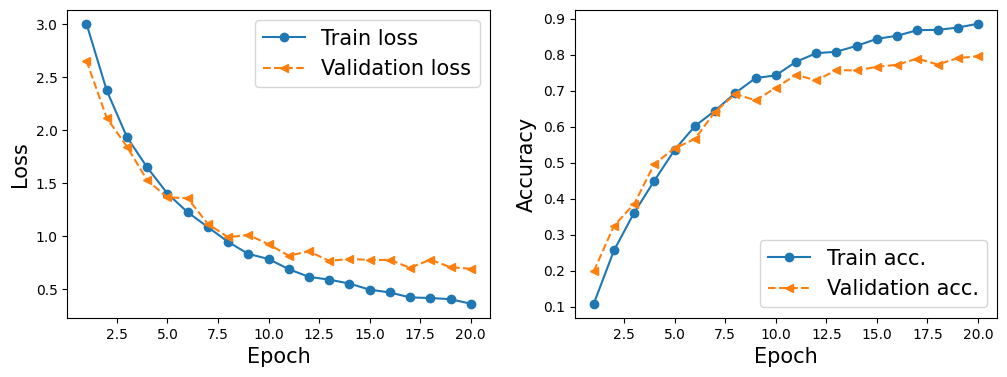

In [162]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize= (12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

AAAAAAAH

2.3 Selecionar aleatoriamente desde el conjunto Test, cinco datos por cada clase. Clasificar los datos utilizando el modelo obtenido en el item anterior. Generar un nuevo DataFrame llamado resultados, que contenga tres columnas: el id de los datos seleccionados, la clasificacion real y la
clasificacion predicha por el modelo.

In [193]:
df = df_test.copy()
resultados =pd.DataFrame()
dfs = []
for i in range(0,28):
    dfs = df[df['class'] == i].sample(5)
    resultados =pd.concat([resultados, dfs])
resultados

,paths,class
1626,Test Images 3360x32x32\test\id_2465_label_1.png,0
258,Test Images 3360x32x32\test\id_1233_label_1.png,0
2312,Test Images 3360x32x32\test\id_3082_label_1.png,0
632,Test Images 3360x32x32\test\id_1570_label_1.png,0
507,Test Images 3360x32x32\test\id_1458_label_1.png,0
...,...,...
504,Test Images 3360x32x32\test\id_1455_label_28.png,27
318,Test Images 3360x32x32\test\id_1288_label_28.png,27
1127,Test Images 3360x32x32\test\id_2015_label_28.png,27
3242,Test Images 3360x32x32\test\id_895_label_28.png,27


In [194]:
indxs = [i for i in range(len(resultados['class']))]
#Dataset
_ds = CustomImageDataset(resultados['paths'], resultados['class'], indxs)
#DataLoader
_dl = DataLoader(_ds,batch_size=batch_size, shuffle = False)

#prediccion del modelo con el conjunto 'valid_dl'
RNNmodel.eval()
_pred = []
_val = []
with torch.no_grad():
    for x, y in _dl:
        x = x.to(device)
        #Se obtene las predicciones del modelo entregandole x del conjunto 'valid_dl'
        pred = RNNmodel(x)
        #El conjunto trabaja con batch size de 128, todos los resultados se acoplan a una lista de tensores, esto se aplica para 
        #el conjunto original y el predicho
        _pred.extend(pred)
        _val.extend(y)
#Funcion que toma los tensores creados anteriormente y los tranfroma a una lista binaria
pred = []
val = []
for tensor1,tensor2 in zip(_pred,_val):
    #La pocision del valor maximo indica a la clase que pertenece
    tensor1 = torch.argmax(tensor1)
    tensor1 = tensor1.to('cpu')
    tensor2 = tensor2.to('cpu')
    valu1 = tensor1.item()
    valu2 = tensor2.tolist()
    pred.append(valu1)
    val.append(valu2)

In [195]:
resultados['predicted_class']= pred
resultados['paths'] = resultados['paths'].str.split("_").str[1]
resultados['paths'] = pd.to_numeric(resultados['paths'])
resultados.rename(columns={'paths': 'ID'}, inplace=True)
resultados = resultados.reset_index(drop=True)
resultados

,ID,class,predicted_class
0,2465,0,0
1,1233,0,0
2,3082,0,0
3,1570,0,0
4,1458,0,0
...,...,...,...
135,1455,27,27
136,1288,27,27
137,2015,27,27
138,895,27,27


2.4 Por cada capa del modelo, calcular la cantidad de parametros (pesos). Agregar el detalle del calculo.

La capa RNN 1-1: tiene una entrada de tamaño (32, 512) que corresponden a (input_size, hidden_size), tiene una matriz de pesos que conecta la entrada con la capa oculta (32 + 512, 512) que corresponden a (input_size + hidden_size, hidden_size) = (544, 512) y tiene el bias (512,0).
Calculo pesos: 32 x 512 + 544 x 512 + 512 = 279,552.

La capa RNN 1-2: tiene una entrada de tamaño (512, 512), tiene una matriz de pesos (512 + 512, 512) = (1024, 512)y tiene el bias (512,0).
Calculo pesos:  512 x 512 + 1024 x 512 + 512 = 525,312.

La capa Linear 1-3: tiene una matriz de pesos de tamaño (512, 28) que corresponde a (hidden_size, num_classes) y el bias (28,0).
Calculo de pesos: 512 x 28 + 28 = 14,364.